In [133]:
# // p2112646
# Justin Wong Juin Hng
# DAAA/1B/04

import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.impute import SimpleImputer
import plotly.express as px
from IPython.core.display import display
pd.set_option('display.max_rows', 200)

# Part A

### Objective:
Build a prediction model in order to predict which machine / component will possibly fail before it actually fails.
<br>
### Task List:
1. How is your prediction task defined? And what is the meaning of the output variable?
2. How do you represent your data as features?
3. Did you process the features in any way?
4. How did you select which learning algorithms to use?
5. Did you try to tune the hyperparameters of the learning algorithm, and in that case how?
6. How do you evaluate the quality of your system?
7. How well does your system compare to a stupid baseline?
8. Can you say anything about the errors that the system makes? For a classification task, you may consider a confusion matrix.
9. Is it possible to say something about which features the model considers important? (Whether this is possible depends on the type of classifier you are using)





<br>

#### How is your prediction task defined?
> My prediction task is defined by: Using the given features, how accurate is my model able to predict which
> machine/component will possibly fail before it actually fails.
#### What is the meaning of the output variable?
> The meaning of the output variable indicates whether the Machine Status; whether the machine failed or not, 1 means
> failure, 0 means normal.
#### How do you represent your data as features?
>In machine learning, a feature is an individual measurable property. In this case, I can represent the column
variables as features in the model, such as `Ambient T (C)` and `Rotation Speed (rpm)`

<br>

## Data Cleaning

In [134]:
#Data Cleaning and Wrangling
df = pd.read_csv('factory_data (classification).csv')

### Features in Dataset:

In [135]:



for column in df.columns:
    print(column)
# sort by quality of product to ensure that filling of empty values will have correlation to final quality of product
# then sort by machine status


Unique ID
Product ID
Quality
Ambient T (C)
Process T (C)
Rotation Speed (rpm)
Torque (Nm)
Tool Wear (min)
Machine Status


<br>

> Drop columns `Unique ID` and `Product ID` because these features are *not* considered relevant to the model and the prediction
of failure of component
> 
> Drop rows with `0` value to ensure reliability of data (does not interfere with mean calculation)

<br>

In [136]:

df = df.drop(['Unique ID', 'Product ID'],axis=1)
df = df.sort_values(by=['Machine Status'],ascending=True)
#drop rows with 0 in value
df.rename(columns = {'Tool Wear (min)':'Tool Lifespan (min)'}, inplace = True)
df = df.loc[(df[['Ambient T (C)', 'Process T (C)','Rotation Speed (rpm)','Torque (Nm)','Tool Lifespan (min)']] != 0).all(axis=1)]
print(df.describe())



       Ambient T (C)  Process T (C)  Rotation Speed (rpm)   Torque (Nm)  \
count   19760.000000   19363.000000          18586.000000  19760.000000   
mean       26.905516      36.904764           1538.948725     39.978715   
std         2.000687       1.483577            179.020043      9.977275   
min        22.150000      32.550000           1168.000000      3.800000   
25%        25.250000      35.750000           1423.000000     33.200000   
50%        26.950000      36.950000           1503.000000     40.100000   
75%        28.450000      37.950000           1612.000000     46.800000   
max        31.450000      40.750000           2886.000000     76.600000   

       Tool Lifespan (min)  Machine Status  
count         19760.000000    19760.000000  
mean            109.262146        0.034008  
std              62.909417        0.181255  
min               2.000000        0.000000  
25%              55.000000        0.000000  
50%             109.000000        0.000000  
75%      

### Imputing Data
> Impute Categorical Data with `most_frequent` and Numerical Data with `mean` using scikit library

<br>

In [137]:
for column in df.columns:
    print('Number of Missing Values in',column,'before cleaning: ',df[column].isnull().sum())


Number of Missing Values in Quality before cleaning:  981
Number of Missing Values in Ambient T (C) before cleaning:  0
Number of Missing Values in Process T (C) before cleaning:  397
Number of Missing Values in Rotation Speed (rpm) before cleaning:  1174
Number of Missing Values in Torque (Nm) before cleaning:  0
Number of Missing Values in Tool Lifespan (min) before cleaning:  0
Number of Missing Values in Machine Status before cleaning:  0


In [138]:
#take out the quality column because it is categorical data and needs to be imputed separately
categorical_df = df['Quality']
categorical_df = categorical_df.reset_index().drop('index',axis=1)

#drop the quality column to ensure no errors during imputation
numerical_df = df.drop('Quality',axis=1)

In [139]:
# imputer class
class numericalImputer(SimpleImputer):
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)
    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)


numerical_df = numericalImputer().fit_transform(numerical_df)
categorical_df = pd.DataFrame(SimpleImputer( strategy='most_frequent').fit_transform(categorical_df), columns = categorical_df.columns)

In [142]:
# stitch the dataframes together into one
cleaned_df =  pd.concat([ categorical_df,numerical_df], axis=1)
for column in cleaned_df.columns:
    print('Number of Missing Values in',column,'after cleaning: ',cleaned_df[column].isnull().sum())

cleaned_df['T Difference Squared (C^2)'] = (cleaned_df['Ambient T (C)']- cleaned_df['Process T (C)'])**2
cleaned_df['Tool Lifespan per Square of Temperature Increase (min/C^2)'] = round(cleaned_df['Tool Lifespan (min)'] /cleaned_df['T Difference Squared (C^2)'])
cleaned_df['Horsepower (HP)'] = (cleaned_df['Rotation Speed (rpm)'] * cleaned_df['Torque (Nm)']) /5252
cleaned_df = cleaned_df.iloc[:, [0,1,2,7,5,8,3,4,9,6]]


Number of Missing Values in Quality after cleaning:  0
Number of Missing Values in Ambient T (C) after cleaning:  0
Number of Missing Values in Process T (C) after cleaning:  0
Number of Missing Values in Rotation Speed (rpm) after cleaning:  0
Number of Missing Values in Torque (Nm) after cleaning:  0
Number of Missing Values in Tool Lifespan (min) after cleaning:  0
Number of Missing Values in Machine Status after cleaning:  0


### Cleaned Dataset

Quality  Ambient T (C)  Process T (C)  T Difference Squared (C^2)  \
0           M          27.05          36.15                       82.81   
1           M          27.15          36.35                       84.64   
2           M          27.15          36.35                       84.64   
3           L          27.05          36.25                       84.64   
4           L          27.05          36.25                       84.64   
...       ...            ...            ...                         ...   
19755       L          24.05          34.75                      114.49   
19756       L          27.35          38.75                      129.96   
19757       L          24.55          36.55                      144.00   
19758       L          27.25          38.65                      129.96   
19759       L          25.15          36.15                      121.00   

       Tool Lifespan (min)  \
0                    211.0   
1                    208.0   
2                    205.0   
3                    203.0   
4                    201.0   
...                    ...   
19755                172.0   
19756                198.0   
19757                222.0   
19758                198.0   
19759                206.0   

       Tool Lifespan per Square of Temperature Increase (min/C^2)  \
0                                                    3.0            
1                                                    2.0            
2                                                    2.0            
3                                                    2.0            
4                                                    2.0            
...                                                  ...            
19755                                                2.0            
19756                                                2.0            
19757                                                2.0            
19758                                                2.0            
19759                                                2.0            

       Rotation Speed (rpm)  Torque (Nm)  Horsepower (HP)  Machine Status  
0               1538.948725         51.0        14.944095             0.0  
1               1752.000000         27.8         9.273724             0.0  
2               1456.000000         48.8        13.528713             0.0  
3               1685.000000         27.1         8.694497             0.0  
4               1654.000000         31.0         9.762757             0.0  
...                     ...          ...              ...             ...  
19755           1326.000000         75.4        19.036634             1.0  
19756           1272.000000         59.2        14.337852             1.0  
19757           1501.000000         49.8        14.232635             1.0  
19758           1272.000000         59.2        14.337852             1.0  
19759           1337.000000         56.1        14.281359             1.0  

[19760 rows x 10 columns]

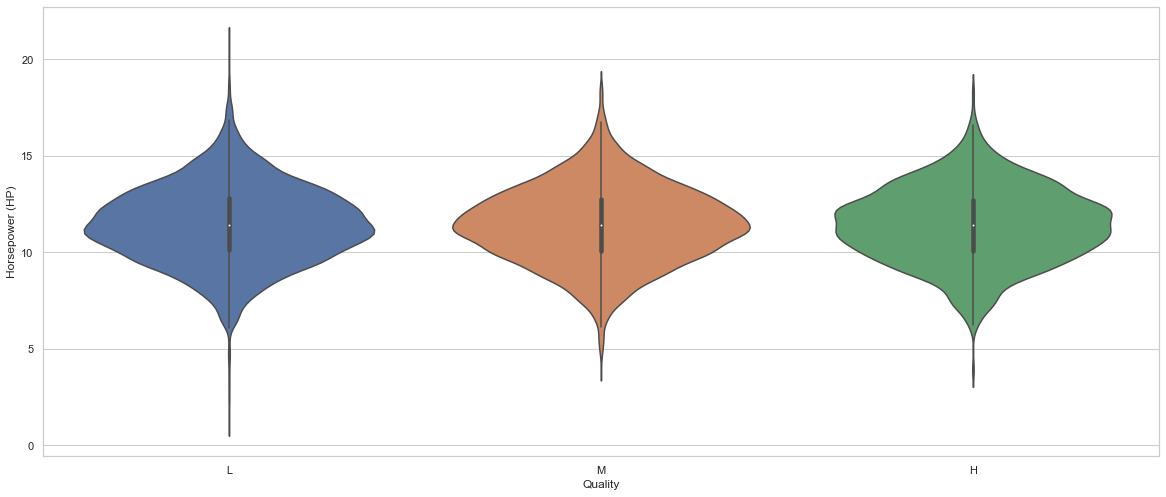

In [143]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set_theme(style="whitegrid")

display(cleaned_df)
fig1 = px.scatter(cleaned_df, x='Rotation Speed (rpm)',y='Torque (Nm)',width=1300, height=600)
fig1.show()
fig2 = px.scatter(cleaned_df, x='T Difference Squared (C^2)',y='Tool Lifespan (min)', trendline="ols",
                  trendline_color_override="red",width=1300, height=600)
fig2.data = fig2.data[::-1]
fig2.show()
ax = sns.violinplot(x="Quality", y="Horsepower (HP)", data=cleaned_df, order=['L','M','H'])

